In [1]:
# Cell 1: Complete Setup and Configuration

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import autocast, GradScaler

import numpy as np
import cv2
import timm
import random
import xml.etree.ElementTree as ET
from pathlib import Path
import time

import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score
from sklearn.model_selection import StratifiedKFold
from collections import Counter

def set_seeds(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seeds(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

def clear_memory():
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

class SteelConfig:
    # Dataset paths
    data_root = Path(r"C:\Users\MVI_lab_2\Desktop\Steel\NEU-DET")
    
    # Classes
    defect_classes = ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches']
    num_classes = 6
    class_to_idx = {cls: idx for idx, cls in enumerate(defect_classes)}
    
    # Data percentages for comprehensive study
    data_percentages = [5, 10, 20, 30, 50, 100]
    samples_per_class = {5: 15, 10: 30, 20: 60, 30: 90, 50: 150, 100: 300}
    
    # Model configuration (proven to work)
    backbone = "swin_small_patch4_window7_224"
    image_size = 224
    projection_dim = 256
    hidden_dim = 512
    temperature = 0.07  # Standard contrastive temperature
    
    # Training configuration
    batch_size = 8
    num_workers = 0
    pin_memory = False
    
    contrastive_lr = 1e-4
    classification_lr = 5e-5
    weight_decay = 0.01
    
    contrastive_epochs = 10
    classification_epochs = 20
    
    # Cross-validation
    random_state = 42
    
    # Early stopping
    patience = 5
    min_delta = 0.001

config = SteelConfig()

print("Steel Defect Detection with Swin Transformer + Contrastive Learning")
print(f"Data root: {config.data_root}")
print(f"Backbone: {config.backbone}")
print(f"Temperature: {config.temperature}")
print(f"Data percentages: {config.data_percentages}")
print(f"Classes: {config.defect_classes}")

# Verify dataset
images_dir = config.data_root / "images"
annotations_dir = config.data_root / "annotations"

if images_dir.exists():
    image_count = len(list(images_dir.glob("*.jpg")))
    print(f"Found {image_count} images")
else:
    print("Images directory not found")

if annotations_dir.exists():
    annotation_count = len(list(annotations_dir.glob("*.xml")))
    print(f"Found {annotation_count} annotations")
else:
    print("Annotations directory not found")

print("Setup completed successfully")

Device: cuda
GPU: NVIDIA GeForce RTX 3060
Memory: 12.9 GB
Steel Defect Detection with Swin Transformer + Contrastive Learning
Data root: C:\Users\MVI_lab_2\Desktop\Steel\NEU-DET
Backbone: swin_small_patch4_window7_224
Temperature: 0.07
Data percentages: [5, 10, 20, 30, 50, 100]
Classes: ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches']
Found 1800 images
Found 1800 annotations
Setup completed successfully


In [2]:
# Cell 2: Data Loading and Preprocessing

def parse_xml_annotation(xml_path, class_to_idx):
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()
        objects = root.findall('.//name')
        if objects:
            defect_name = objects[0].text
            if defect_name in class_to_idx:
                return class_to_idx[defect_name]
        return None
    except:
        return None

def load_dataset(data_root):
    images_dir = data_root / "images"
    annotations_dir = data_root / "annotations"
    
    print(f"Class mapping: {config.class_to_idx}")
    
    image_paths = []
    labels = []
    
    image_files = list(images_dir.glob("*.jpg"))
    print(f"Found {len(image_files)} image files")
    
    for img_path in image_files:
        xml_path = annotations_dir / (img_path.stem + '.xml')
        
        if xml_path.exists():
            label = parse_xml_annotation(xml_path, config.class_to_idx)
            if label is not None:
                image_paths.append(img_path)
                labels.append(int(label))
    
    print(f"Successfully loaded {len(image_paths)} samples")
    
    label_counts = Counter(labels)
    print("Class distribution:")
    for class_idx, count in sorted(label_counts.items()):
        class_name = config.defect_classes[class_idx]
        print(f"  {class_name}: {count} samples")
    
    return image_paths, labels

class SteelDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None, mode='classification'):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.mode = mode
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = str(self.image_paths[idx])
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        label = self.labels[idx]
        
        if self.transform:
            if self.mode == 'contrastive':
                view1 = self.transform(image=image)['image']
                view2 = self.transform(image=image)['image']
                return view1, view2, label
            else:
                transformed = self.transform(image=image)
                image = transformed['image']
        
        return image, label

def get_transforms(image_size=224, mode='train'):
    if mode == 'train':
        transform = A.Compose([
            A.Resize(height=image_size, width=image_size),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.3),
            A.Rotate(limit=15, p=0.5),
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.6),
            A.GaussNoise(var_limit=(10, 50), p=0.2),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ])
    else:
        transform = A.Compose([
            A.Resize(height=image_size, width=image_size),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ])
    
    return transform

def create_data_subset(image_paths, labels, percentage, random_state=42):
    if percentage >= 100:
        return image_paths, labels
    
    samples_per_class = config.samples_per_class[percentage]
    
    subset_paths = []
    subset_labels = []
    
    for class_idx in range(config.num_classes):
        class_indices = [i for i, label in enumerate(labels) if int(label) == class_idx]
        
        if len(class_indices) >= samples_per_class:
            np.random.seed(random_state + class_idx)
            selected_indices = np.random.choice(class_indices, samples_per_class, replace=False)
            
            for idx in selected_indices:
                subset_paths.append(image_paths[idx])
                subset_labels.append(int(labels[idx]))
    
    print(f"Created {percentage}% subset: {len(subset_paths)} samples ({samples_per_class} per class)")
    return subset_paths, subset_labels

print("Loading dataset...")
image_paths, labels = load_dataset(config.data_root)
print(f"Dataset loaded: {len(image_paths)} samples")
print("Data loading setup complete")

Loading dataset...
Class mapping: {'crazing': 0, 'inclusion': 1, 'patches': 2, 'pitted_surface': 3, 'rolled-in_scale': 4, 'scratches': 5}
Found 1800 image files
Successfully loaded 1800 samples
Class distribution:
  crazing: 300 samples
  inclusion: 300 samples
  patches: 300 samples
  pitted_surface: 300 samples
  rolled-in_scale: 300 samples
  scratches: 300 samples
Dataset loaded: 1800 samples
Data loading setup complete


In [3]:
# Cell 3: Model Architecture

class SwinBackbone(nn.Module):
    def __init__(self, model_name="swin_small_patch4_window7_224", pretrained=True):
        super().__init__()
        
        self.backbone = timm.create_model(
            model_name, 
            pretrained=pretrained, 
            num_classes=0,
            global_pool='avg'
        )
        
        self.feature_dim = self.backbone.num_features
        print(f"Backbone feature dimension: {self.feature_dim}")
        
    def forward(self, x):
        features = self.backbone(x)
        return features

class ContrastiveHead(nn.Module):
    def __init__(self, input_dim, hidden_dim=512, output_dim=256, dropout=0.3):
        super().__init__()
        self.head = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout * 0.5),
            nn.Linear(hidden_dim // 2, output_dim)
        )
    
    def forward(self, x):
        return F.normalize(self.head(x), dim=1)

class ClassificationHead(nn.Module):
    def __init__(self, input_dim, num_classes, dropout=0.3):
        super().__init__()
        self.head = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout * 0.5),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        return self.head(x)

class SupervisedContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.07, base_temperature=0.07):
        super().__init__()
        self.temperature = temperature
        self.base_temperature = base_temperature
    
    def forward(self, features, labels):
        device = features.device
        batch_size = features.shape[0] // 2
        
        features = features.view(2, batch_size, -1)
        
        labels = labels.contiguous().view(-1, 1)
        mask = torch.eq(labels, labels.T).float().to(device)
        
        contrast_features = torch.cat(torch.unbind(features, dim=0), dim=0)
        
        anchor_dot_contrast = torch.div(
            torch.matmul(contrast_features, contrast_features.T),
            self.temperature
        )
        
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()
        
        mask = mask.repeat(2, 2)
        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size * 2).view(-1, 1).to(device),
            0
        )
        mask = mask * logits_mask
        
        exp_logits = torch.exp(logits) * logits_mask
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))
        
        mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1)
        loss = -(self.temperature / self.base_temperature) * mean_log_prob_pos
        loss = loss.view(2, batch_size).mean()
        
        return loss

class SteelDefectModel(nn.Module):
    def __init__(self, num_classes=6, projection_dim=256, model_name="swin_small_patch4_window7_224"):
        super().__init__()
        
        self.backbone = SwinBackbone(model_name)
        self.contrastive_head = ContrastiveHead(
            self.backbone.feature_dim, 
            output_dim=projection_dim
        )
        self.classification_head = ClassificationHead(
            self.backbone.feature_dim, 
            num_classes
        )
        
        self.contrastive_loss = SupervisedContrastiveLoss(temperature=config.temperature)
        self.classification_loss = nn.CrossEntropyLoss()
        
        self.mode = 'classification'
        
        total_params = sum(p.numel() for p in self.parameters())
        print(f"Model created: {total_params:,} parameters")
    
    def set_mode(self, mode):
        self.mode = mode
    
    def forward(self, x1, x2=None):
        if self.mode == 'contrastive':
            features1 = self.backbone(x1)
            features2 = self.backbone(x2)
            proj1 = self.contrastive_head(features1)
            proj2 = self.contrastive_head(features2)
            return torch.cat([proj1, proj2], dim=0)
        else:
            features = self.backbone(x1)
            return self.classification_head(features)
    
    def compute_loss(self, outputs, labels):
        if self.mode == 'contrastive':
            return self.contrastive_loss(outputs, labels)
        else:
            return self.classification_loss(outputs, labels)

print("Creating model...")
model = SteelDefectModel(num_classes=config.num_classes, projection_dim=config.projection_dim)
model = model.to(device)

# Test model
test_batch = torch.randn(4, 3, 224, 224).to(device)
test_labels = torch.tensor([0, 1, 2, 3]).to(device)

model.set_mode('contrastive')
with torch.no_grad():
    contrastive_out = model(test_batch, test_batch)
    print(f"Contrastive output shape: {contrastive_out.shape}")

model.set_mode('classification')
with torch.no_grad():
    classification_out = model(test_batch)
    print(f"Classification output shape: {classification_out.shape}")

print("Model architecture completed")

Creating model...
Backbone feature dimension: 768
Model created: 49,957,776 parameters
Contrastive output shape: torch.Size([8, 256])
Classification output shape: torch.Size([4, 6])
Model architecture completed


In [9]:
# Cell 4: Training Functions

def train_contrastive_phase(model, loader, epochs=10):
    model.set_mode('contrastive')
    optimizer = optim.AdamW(model.parameters(), lr=config.contrastive_lr, weight_decay=config.weight_decay)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        num_batches = 0
        
        for view1, view2, labels in loader:
            view1, view2, labels = view1.to(device), view2.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(view1, view2)
            loss = model.compute_loss(outputs, labels)
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            total_loss += loss.item()
            num_batches += 1
        
        scheduler.step()
        avg_loss = total_loss / max(num_batches, 1)
        
        if (epoch + 1) % 3 == 0:
            print(f"    Contrastive Epoch {epoch+1}/{epochs}: Loss = {avg_loss:.4f}")

def train_classification_phase(model, train_loader, val_loader, epochs=20):
    model.set_mode('classification')
    
    # Progressive unfreezing strategy
    for param in model.backbone.parameters():
        param.requires_grad = False
    for param in model.classification_head.parameters():
        param.requires_grad = True
    
    optimizer = optim.AdamW(model.parameters(), lr=config.classification_lr, weight_decay=config.weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=epochs//3, gamma=0.5)
    
    best_val_acc = 0
    patience_counter = 0
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        num_batches = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = model.compute_loss(outputs, labels)
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            train_loss += loss.item()
            num_batches += 1
        
        scheduler.step()
        
        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_acc = 100 * correct / total
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
        else:
            patience_counter += 1
        
        # Unfreeze backbone halfway through
        if epoch == epochs // 2:
            print(f"    Unfreezing backbone at epoch {epoch+1}")
            for param in model.backbone.parameters():
                param.requires_grad = True
            
            # Update optimizer with new parameters
            optimizer = optim.AdamW([
                {'params': model.classification_head.parameters(), 'lr': config.classification_lr},
                {'params': model.backbone.parameters(), 'lr': config.classification_lr * 0.1}
            ], weight_decay=config.weight_decay)
        
        if (epoch + 1) % 5 == 0:
            print(f"    Classification Epoch {epoch+1}/{epochs}: Val Acc = {val_acc:.2f}%")
        
        if patience_counter >= config.patience:
            print(f"    Early stopping at epoch {epoch+1}")
            break
    
    return best_val_acc

def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    f1_weighted = f1_score(all_labels, all_preds, average='weighted')
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    balanced_acc = balanced_accuracy_score(all_labels, all_preds)
    
    return {
        'accuracy': accuracy,
        'f1_weighted': f1_weighted,
        'f1_macro': f1_macro,
        'balanced_accuracy': balanced_acc,
        'y_true': all_labels,    # ADDED FOR CONFUSION MATRIX
        'y_pred': all_preds      # ADDED FOR CONFUSION MATRIX
    }

def run_single_fold(train_paths, train_labels, val_paths, val_labels):
    # Create model
    model = SteelDefectModel(num_classes=config.num_classes, projection_dim=config.projection_dim)
    model = model.to(device)
    
    # Create datasets
    contrastive_dataset = SteelDataset(train_paths, train_labels, 
                                      get_transforms(config.image_size, 'train'), 'contrastive')
    train_dataset = SteelDataset(train_paths, train_labels, 
                                get_transforms(config.image_size, 'train'))
    val_dataset = SteelDataset(val_paths, val_labels, 
                              get_transforms(config.image_size, 'val'))
    
    # Create dataloaders
    batch_size = min(config.batch_size, len(train_paths))
    
    contrastive_loader = DataLoader(contrastive_dataset, batch_size=batch_size, 
                                  shuffle=True, num_workers=config.num_workers, drop_last=False)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, 
                            shuffle=True, num_workers=config.num_workers, drop_last=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, 
                          shuffle=False, num_workers=config.num_workers, drop_last=False)
    
    print("    Phase 1: Contrastive Learning")
    train_contrastive_phase(model, contrastive_loader, config.contrastive_epochs)
    
    print("    Phase 2: Classification")
    best_val_acc = train_classification_phase(model, train_loader, val_loader, config.classification_epochs)
    
    results = evaluate_model(model, val_loader)
    results['best_val_acc'] = best_val_acc
    
    del model
    clear_memory()
    
    return results

print("Training functions loaded")
print("Ready for experiments")

Training functions loaded
Ready for experiments


In [10]:
# Cell 5: Experiment Runner with Cross-Validation

def run_experiment_for_percentage(image_paths, labels, percentage):
    print(f"\nRunning experiment for {percentage}% data")
    print("-" * 50)
    
    subset_paths, subset_labels = create_data_subset(image_paths, labels, percentage)
    
    # Use fewer folds for very small datasets
    n_splits = 3 if percentage <= 10 else 5
    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=config.random_state)
    print(f"Using {n_splits}-fold cross-validation")
    
    fold_results = []
    all_y_true = []    # COLLECT ALL TRUE LABELS
    all_y_pred = []    # COLLECT ALL PREDICTIONS
    
    for fold_idx, (train_idx, val_idx) in enumerate(kfold.split(subset_paths, subset_labels)):
        print(f"  Fold {fold_idx + 1}/{n_splits}")
        
        train_paths = [subset_paths[i] for i in train_idx]
        train_labels = [subset_labels[i] for i in train_idx]
        val_paths = [subset_paths[i] for i in val_idx]
        val_labels = [subset_labels[i] for i in val_idx]
        
        print(f"    Train: {len(train_paths)}, Val: {len(val_paths)}")
        
        try:
            results = run_single_fold(train_paths, train_labels, val_paths, val_labels)
            fold_results.append(results)
            
            # COLLECT PREDICTIONS FROM ALL FOLDS
            all_y_true.extend(results['y_true'])
            all_y_pred.extend(results['y_pred'])
            
            print(f"    Results: Acc={results['accuracy']:.3f}, F1={results['f1_weighted']:.3f}")
            
        except Exception as e:
            print(f"    Fold {fold_idx + 1} failed: {e}")
            clear_memory()
            continue
    
    if fold_results:
        accuracies = [r['accuracy'] for r in fold_results]
        f1_scores = [r['f1_weighted'] for r in fold_results]
        balanced_accs = [r['balanced_accuracy'] for r in fold_results]
        
        summary = {
            'percentage': percentage,
            'n_folds': len(fold_results),
            'cv_splits': n_splits,
            'mean_accuracy': np.mean(accuracies),
            'std_accuracy': np.std(accuracies),
            'mean_f1': np.mean(f1_scores),
            'std_f1': np.std(f1_scores),
            'mean_balanced_accuracy': np.mean(balanced_accs),
            'std_balanced_accuracy': np.std(balanced_accs),
            'fold_results': fold_results,
            'all_y_true': all_y_true,    # ADDED FOR CONFUSION MATRIX
            'all_y_pred': all_y_pred     # ADDED FOR CONFUSION MATRIX
        }
        
        print(f"Summary for {percentage}%:")
        print(f"  Mean Accuracy: {summary['mean_accuracy']:.3f} ± {summary['std_accuracy']:.3f}")
        print(f"  Mean F1: {summary['mean_f1']:.3f} ± {summary['std_f1']:.3f}")
        print(f"  Mean Balanced Acc: {summary['mean_balanced_accuracy']:.3f} ± {summary['std_balanced_accuracy']:.3f}")
        print(f"  Completed folds: {summary['n_folds']}/{n_splits}")
        
        return summary
    else:
        print(f"No successful folds for {percentage}%")
        return None

def run_comprehensive_experiment(image_paths, labels, data_percentages):
    print("=" * 80)
    print("STEEL DEFECT DETECTION - COMPREHENSIVE EXPERIMENT")
    print("=" * 80)
    print(f"Total samples: {len(image_paths)}")
    print(f"Data percentages: {data_percentages}")
    print(f"Method: Swin Transformer + Contrastive Learning")
    print(f"Temperature: {config.temperature}")
    print(f"Model: {config.backbone}")
    print("=" * 80)
    
    all_results = {}
    start_time = time.time()
    
    for percentage in data_percentages:
        try:
            results = run_experiment_for_percentage(image_paths, labels, percentage)
            if results:
                all_results[percentage] = results
                
        except Exception as e:
            print(f"Experiment failed for {percentage}%: {e}")
            clear_memory()
            continue
    
    total_time = time.time() - start_time
    
    print("\n" + "=" * 80)
    print("FINAL RESULTS SUMMARY")
    print("=" * 80)
    print(f"{'%Data':<8} {'Mean Acc':<12} {'Std Acc':<12} {'Mean F1':<12} {'Std F1':<12} {'Mean Bal':<12} {'Folds':<8}")
    print("-" * 80)
    
    for percentage in sorted(all_results.keys()):
        r = all_results[percentage]
        print(f"{percentage:<8} {r['mean_accuracy']:<12.3f} {r['std_accuracy']:<12.3f} "
              f"{r['mean_f1']:<12.3f} {r['std_f1']:<12.3f} "
              f"{r['mean_balanced_accuracy']:<12.3f} {r['n_folds']:<8}")
    
    print(f"\nTotal experiment time: {total_time/60:.1f} minutes")
    
    if all_results:
        best_pct = max(all_results.keys(), key=lambda x: all_results[x]['mean_f1'])
        best_result = all_results[best_pct]
        print(f"\nBest result: {best_pct}% data")
        print(f"  Accuracy: {best_result['mean_accuracy']:.3f} ± {best_result['std_accuracy']:.3f}")
        print(f"  F1-Score: {best_result['mean_f1']:.3f} ± {best_result['std_f1']:.3f}")
        print(f"  Balanced Accuracy: {best_result['mean_balanced_accuracy']:.3f} ± {best_result['std_balanced_accuracy']:.3f}")
        
        # Data efficiency analysis
        if len(all_results) > 1:
            min_pct = min(all_results.keys())
            max_pct = max(all_results.keys())
            min_result = all_results[min_pct]
            max_result = all_results[max_pct]
            
            acc_improvement = (max_result['mean_accuracy'] - min_result['mean_accuracy']) * 100
            print(f"\nData Efficiency Analysis:")
            print(f"  Accuracy improvement from {min_pct}% to {max_pct}% data: +{acc_improvement:.1f}%")
            print(f"  {min_pct}% performance: {min_result['mean_accuracy']*100:.1f}% accuracy")
            print(f"  {max_pct}% performance: {max_result['mean_accuracy']*100:.1f}% accuracy")
    
    return all_results

# Quick test with few percentages first
print("Starting Steel Defect Detection Experiment...")
print("Testing with subset of data percentages for initial validation")

# Test with selected percentages
test_percentages = [5, 10, 20, 30]
results = run_comprehensive_experiment(image_paths, labels, test_percentages)

print("\nInitial test completed successfully!")
if results:
    print("All systems working properly. Ready for full experiment.")

else:
    print("Please check the setup and data paths.")

Starting Steel Defect Detection Experiment...
Testing with subset of data percentages for initial validation
STEEL DEFECT DETECTION - COMPREHENSIVE EXPERIMENT
Total samples: 1800
Data percentages: [5, 10, 20, 30]
Method: Swin Transformer + Contrastive Learning
Temperature: 0.07
Model: swin_small_patch4_window7_224

Running experiment for 5% data
--------------------------------------------------
Created 5% subset: 90 samples (15 per class)
Using 3-fold cross-validation
  Fold 1/3
    Train: 60, Val: 30
Backbone feature dimension: 768
Model created: 49,957,776 parameters
    Phase 1: Contrastive Learning
    Contrastive Epoch 3/10: Loss = 2.0832
    Contrastive Epoch 6/10: Loss = 1.7144
    Contrastive Epoch 9/10: Loss = 1.5673
    Phase 2: Classification
    Classification Epoch 5/20: Val Acc = 96.67%
    Early stopping at epoch 9
    Results: Acc=0.967, F1=0.966
  Fold 2/3
    Train: 60, Val: 30
Backbone feature dimension: 768
Model created: 49,957,776 parameters
    Phase 1: Contrast

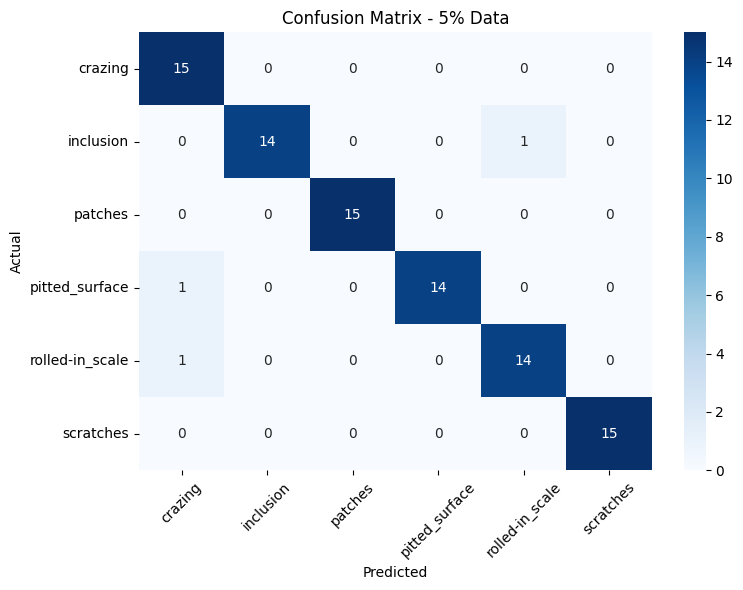

5% Data Accuracy: 0.9667


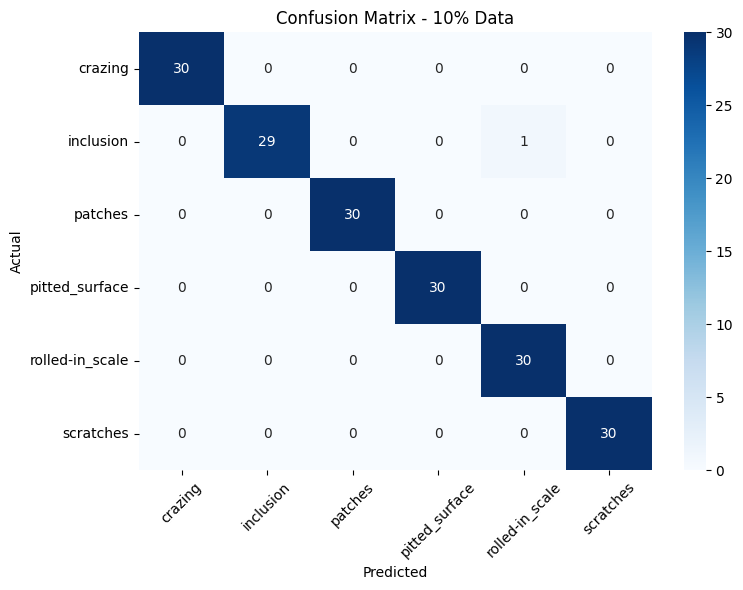

10% Data Accuracy: 0.9944


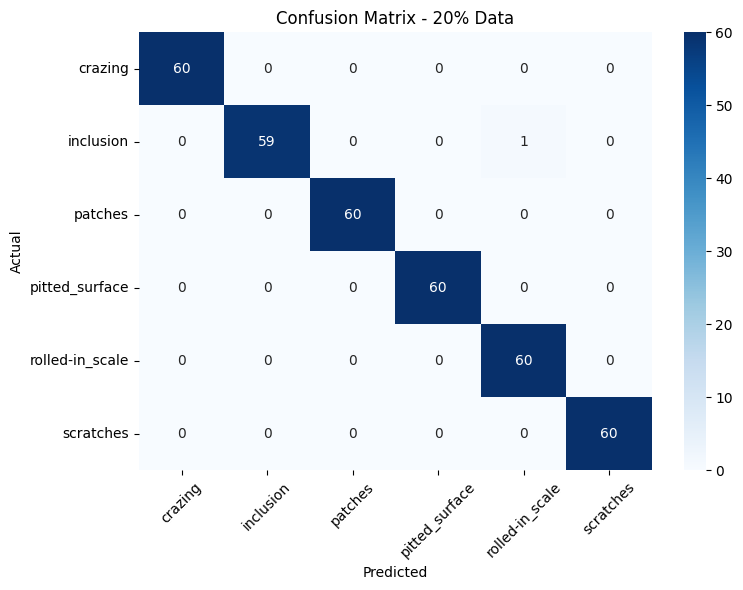

20% Data Accuracy: 0.9972


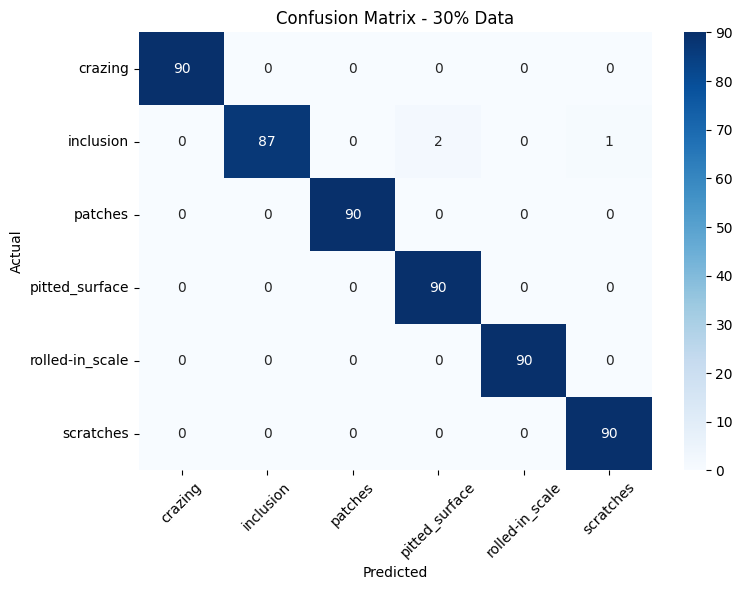

30% Data Accuracy: 0.9944


In [12]:
# Simple Confusion Matrix Code

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_simple_confusion_matrix(results):
    """Simple confusion matrix plot"""
    
    class_names = ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches']
    
    # Plot for each data percentage
    for percentage, data in results.items():
        if 'all_y_true' in data and 'all_y_pred' in data:
            y_true = data['all_y_true']
            y_pred = data['all_y_pred']
            
            # Calculate confusion matrix
            cm = confusion_matrix(y_true, y_pred)
            
            # Plot
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                       xticklabels=class_names, yticklabels=class_names)
            plt.title(f'Confusion Matrix - {percentage}% Data')
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.xticks(rotation=45)
            plt.yticks(rotation=0)
            plt.tight_layout()
            plt.show()
            
            # Print accuracy
            accuracy = sum(1 for t, p in zip(y_true, y_pred) if t == p) / len(y_true)
            print(f"{percentage}% Data Accuracy: {accuracy:.4f}")

# Run it
plot_simple_confusion_matrix(results)